In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from torchsummary import summary

import matplotlib.pyplot as plt
from hydra import compose, initialize
from omegaconf import OmegaConf

from tqdm import tqdm
import random
import numpy as np

import matplotlib.patches as mpatches

from src.data.bvisa_augm_dm import CS_Dataset
from src.data.self_supervised_dm import ContrastiveDataSet

In [2]:
from typing import List, Optional, Tuple

import torch
import hydra
import pyrootutils
import pytorch_lightning as pl
from omegaconf import DictConfig
from pytorch_lightning import (Callback, LightningDataModule, LightningModule,
                               Trainer)
from pytorch_lightning.loggers import TensorBoardLogger

# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)

import src.utils.default as utils

log = utils.get_pylogger(__name__)

torch.set_float32_matmul_precision('medium')
# torch.autograd.set_detect_anomaly(True)

In [3]:
####### CHANGE
EXP_NAME = 'logs_sst/synthseg-monai-BasicUnet-1.5x-half/runs/2023-04-13_16-13-49'
CHKPT = '/mrhome/vladyslavz/git/central-sulcus-analysis/logs_sst/synthseg-monai-BasicUnet-1.5x-half/runs/2023-04-13_16-13-49/checkpoints/epoch-251_val_loss-0.000.ckpt'
####### CHANGE


logging_path = '/mrhome/vladyslavz/git/central-sulcus-analysis'

In [4]:
cfg = OmegaConf.load(f'{logging_path}/{EXP_NAME}/.hydra/config.yaml')

log.info(f"Instantiating datamodule <{cfg.data._target_}>")
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.data)

log.info(f"Instantiating model <{cfg.model._target_}>")
model: LightningModule = hydra.utils.instantiate(cfg.model)


2023-04-26 11:35:46,044 - Instantiating datamodule <src.data.self_supervised_dm.ContrastiveDataModule>
2023-04-26 11:35:46,064 - Len of train examples 16 len of validation examples 4
2023-04-26 11:35:46,065 - Instantiating model <src.models.simclr.SimCLR>
BasicUNet features: (16, 32, 64, 128, 256, 32).
U-Net Embedding dimension: 32000


Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


In [5]:
via11DS = ContrastiveDataSet('via11', 'validation',
                             use_2x2x2_preproc=False,
                             croppadd2samesize='171-171-171',
                             skull_strip=False,
                             crop2content=True,
                             resample=(1.3, 1.3, 1.3)
)
len(via11DS)

101

In [15]:
model = model.load_from_checkpoint(CHKPT, encoder=hydra.utils.instantiate(cfg.model.encoder)).to('cuda')
model = model.eval()

BasicUNet features: (16, 32, 64, 128, 256, 32).
U-Net Embedding dimension: 32000


Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


In [16]:
def generate_embedings(repeats: int, val_dataset, model, max_val=4):
    res_labels = []
    res_embeds = []
    for i in tqdm(range(repeats)):
        val_imgs = []

        for i in range(min(max_val, len(val_dataset))):
            val_imgs.append(torch.stack(val_dataset[i][0]))
        val_imgs = torch.stack(val_imgs)

        val_embeddings = []
        for i in range(min(max_val, len(val_dataset))):
            with torch.no_grad():
                val_embeddings.append(model(val_imgs[i].to('cuda')))
            
        flat_embed = torch.concat(val_embeddings, dim=0)
        flat_labels = [i for i in range(len(val_embeddings)) for j in range(len(val_embeddings[i]))]
        
        res_labels.extend(flat_labels)
        res_embeds.append(flat_embed)

    return res_labels, torch.stack(res_embeds).squeeze(0).flatten(0,1)

In [34]:
dataset_skullstripped = datamodule.val_dataset
# dataset_skullstripped.skull_strip = False

labels_skullrtipped, embeddings_skullrtipped  = generate_embedings(100, dataset_skullstripped, model)

  0%|          | 0/100 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [17]:
labels_via11, embeddings_via11  = generate_embedings(100, via11DS, model)

100%|██████████| 100/100 [11:16<00:00,  6.77s/it]


In [10]:
# dataset_notskullstripped = datamodule.val_dataset
# dataset_notskullstripped.skull_strip = False

# labels_notskullstripped, embeddings_notskullstripped  = generate_embedings(100, dataset_notskullstripped, model)
# labels_notskullstripped = [x + 4 for x in labels_notskullstripped]

In [18]:
embeddings = embeddings_via11
labels = labels_via11

In [9]:
embeddings = embeddings_skullrtipped  # torch.concatenate((embeddings_skullrtipped, embeddings_notskullstripped), dim=0)
labels = labels_skullrtipped  #+ labels_notskullstripped

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, n_iter=1000,
            n_jobs=10, perplexity=30.0,)

tsne_results = tsne.fit_transform(embeddings.cpu().numpy())


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.000s...
[t-SNE] Computed neighbors for 800 samples in 0.241s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 3.975983
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.852242
[t-SNE] KL divergence after 1000 iterations: -0.861600


In [20]:
all_label_colors = list(plt.get_cmap('tab20').colors)
# random.shuffle(all_label_colors)
all_label_colors = [all_label_colors[i] for i in [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]]
label_colors = [all_label_colors[i] for i in labels]

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


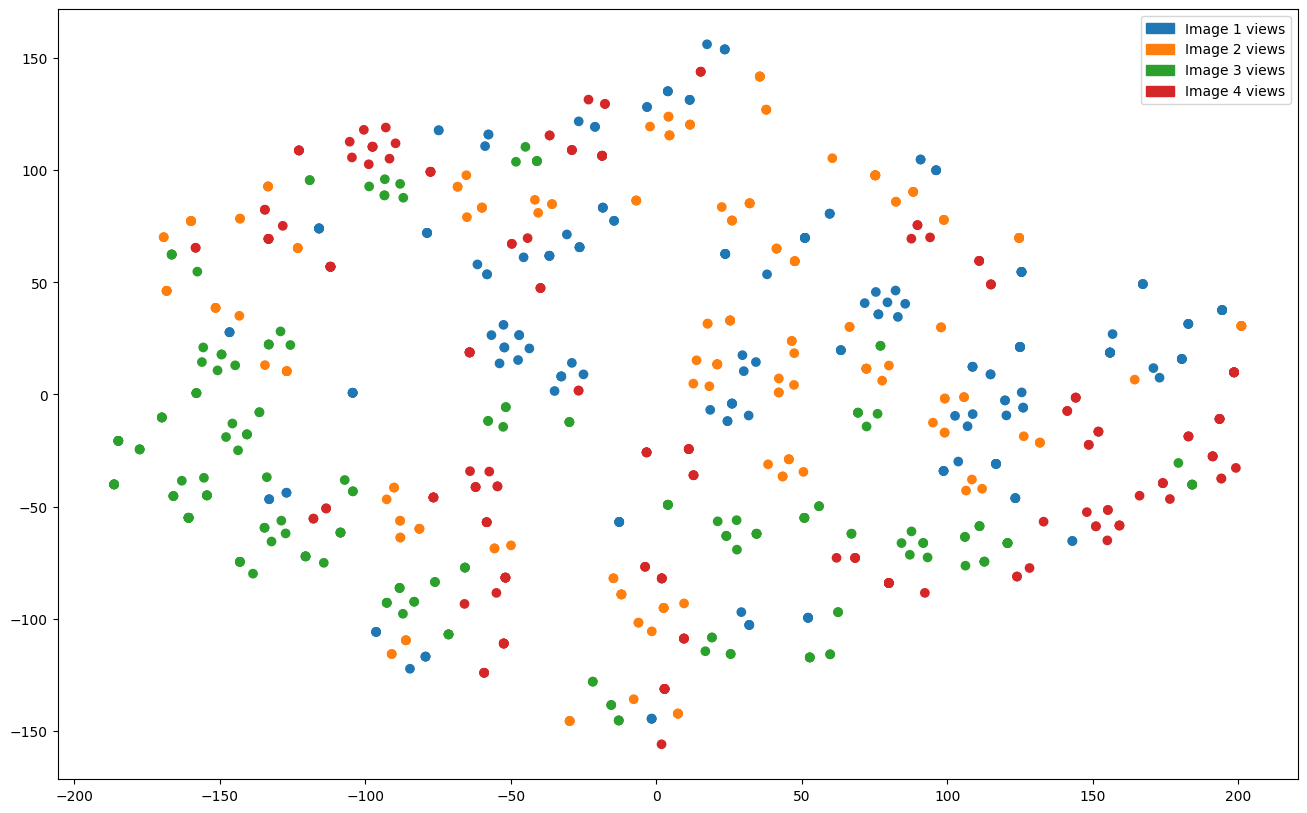

In [21]:
plt.figure(figsize=(16,10))

plt.scatter(tsne_results[:,0], tsne_results[:,1], c=label_colors, cmap='tab20')

patches_list = []

for col in np.unique(labels):
    if col <=3:
        patches_list.append(mpatches.Patch(color=all_label_colors[col], label=f'Image {col + 1} views'))
    else:
        patches_list.append(mpatches.Patch(color=all_label_colors[col], label=f'Image {col - 3} views'))

plt.legend(handles=patches_list)

plt.show()

# Others

torch.Size([1, 171, 171, 171])


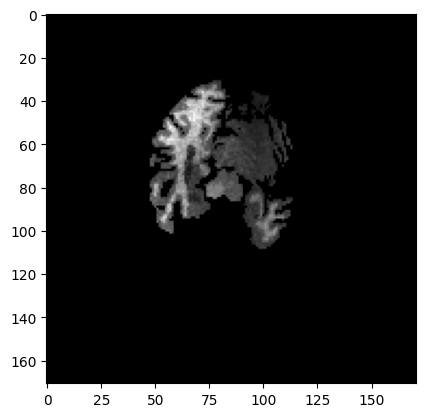

In [21]:
bvisa_img = datamodule.val_dataset[1][0][1]
plt.imshow(bvisa_img[0, 90, :, :], cmap='gray')
print(bvisa_img.shape)

(1, 171, 171, 171)


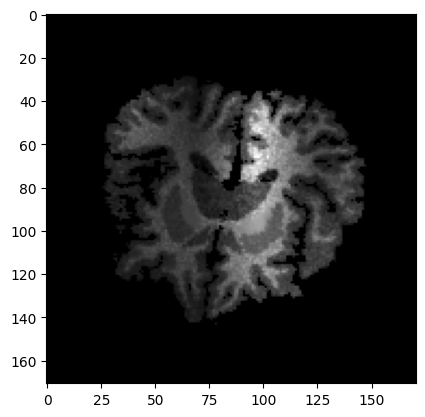

In [22]:
via_img = via11DS[0][0][0].cpu().numpy()
plt.imshow(via_img[0, 90, :, :], cmap='gray')
print(via_img.shape)